# Sequential rumour stance prediction

For my 'sequential domain adaptation' project I am looking into classification problems where the training and test samples originate from different distributions. This type of scenario occurs often. Knowledge of how classifiers may "adapt" to account for differences between underlying distributions is crucial to improving machine learning systems. The main problem in domain adaptation is that the "domains" are often very dissimilar, which means that there is a lot of uncertainty about the adaptation step.

Instead of adapting to a very dissimilar domain, the problem might be a lot easier if we would find "intermediate" domains and perform a sequence of small adaptation steps. Rumours tend to change over time; people discuss different aspects of the story. If we were to characterize expressions using a Bag-of-Words encoding, then one could view this process as a distribution over words that evolves over time. The same is still true for other encodings, but the example is less intuitive.

But people sleep. Which means that the change in word-use-statistics is larger _between_ days than _within_ days. It is difficult to classify a continuously changing process, but given a nearly 'piecewise-constant' process, we could learn something about the rumour today, and adapt to the different situtation tomorrow. 

In [1]:
import numpy as np
import pandas as pd
import pickle as pc
import dateutil

# Import feature extractors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize.api import StringTokenizer
from nltk.tokenize import TweetTokenizer

# Import visualizers
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Import classifiers
import sys
sys.path.append("..")
from iwclf import ImportanceWeightedClassifier
from sklearn import svm
from sklearn import linear_model

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Set font size
fS = 20

In [3]:
# Experimental parameters
which_rumour = 'charliehebdo'
classifier = 'svc'
kernel = 'poly'
degree = 2
l2 = 10

In [4]:
# Load data
X = np.load('../data/RumEval2019/rumeval19.npy')
tweets = pd.read_json('../data/RumEval2019/RumEval19.json')

X[np.isnan(X)] = 0

In [5]:
# Show rumours
rumours_ = tweets['rumour'].tolist()
rumours = np.unique(tweets['rumour'].tolist())
print(rumours)

['charliehebdo' 'ebola-essien' 'ferguson' 'germanwings-crash' 'illary'
 'ottawashooting' 'prince-toronto' 'putinmissing' 'sydneysiege']


In [6]:
# Show dates
# dates_ = [dateutil.parser.parse(date).date() for date in tweets['date'].tolist()]
dates_ = [date.date() for date in tweets['date'].tolist()]
dates = np.unique(dates_)

## Sequential prediction over days within 1 rumour

In [7]:
# Subselect rumour 'charliehebdo'
tweets_r = tweets[tweets['rumour'] == which_rumour]

In [8]:
# Subselect embeddings
X = X[(tweets['rumour'] == which_rumour).values, :]

In [9]:
# Map data to bag-of-words format
# tW = TweetTokenizer(strip_handles=True).tokenize
# tV = CountVectorizer(stop_words='english', analyzer='word', tokenizer=tW, strip_accents='unicode', lowercase=True)

# T = np.array(tV.fit_transform(tweets).todense())
# F = np.array(tV.get_feature_names())

In [10]:
# Reduce dimensionality
# X = PCA(n_components=10).fit_transform(X)
Xb = TSNE(n_components=2).fit_transform(X)

In [11]:
# Subselect labels and map to numerical
labels_ = tweets_r['label'].values.tolist()
labels = np.unique(labels_)
Y = np.array([np.argwhere(label == labels)[0][0] for label in labels_])

In [12]:
# Subselect dates
dates_ = tweets_r['date'].values
dates = np.unique(tweets_r['date'])

In [13]:
# PCA on data
# Bp = PCA(n_components=2).fit_transform(B)

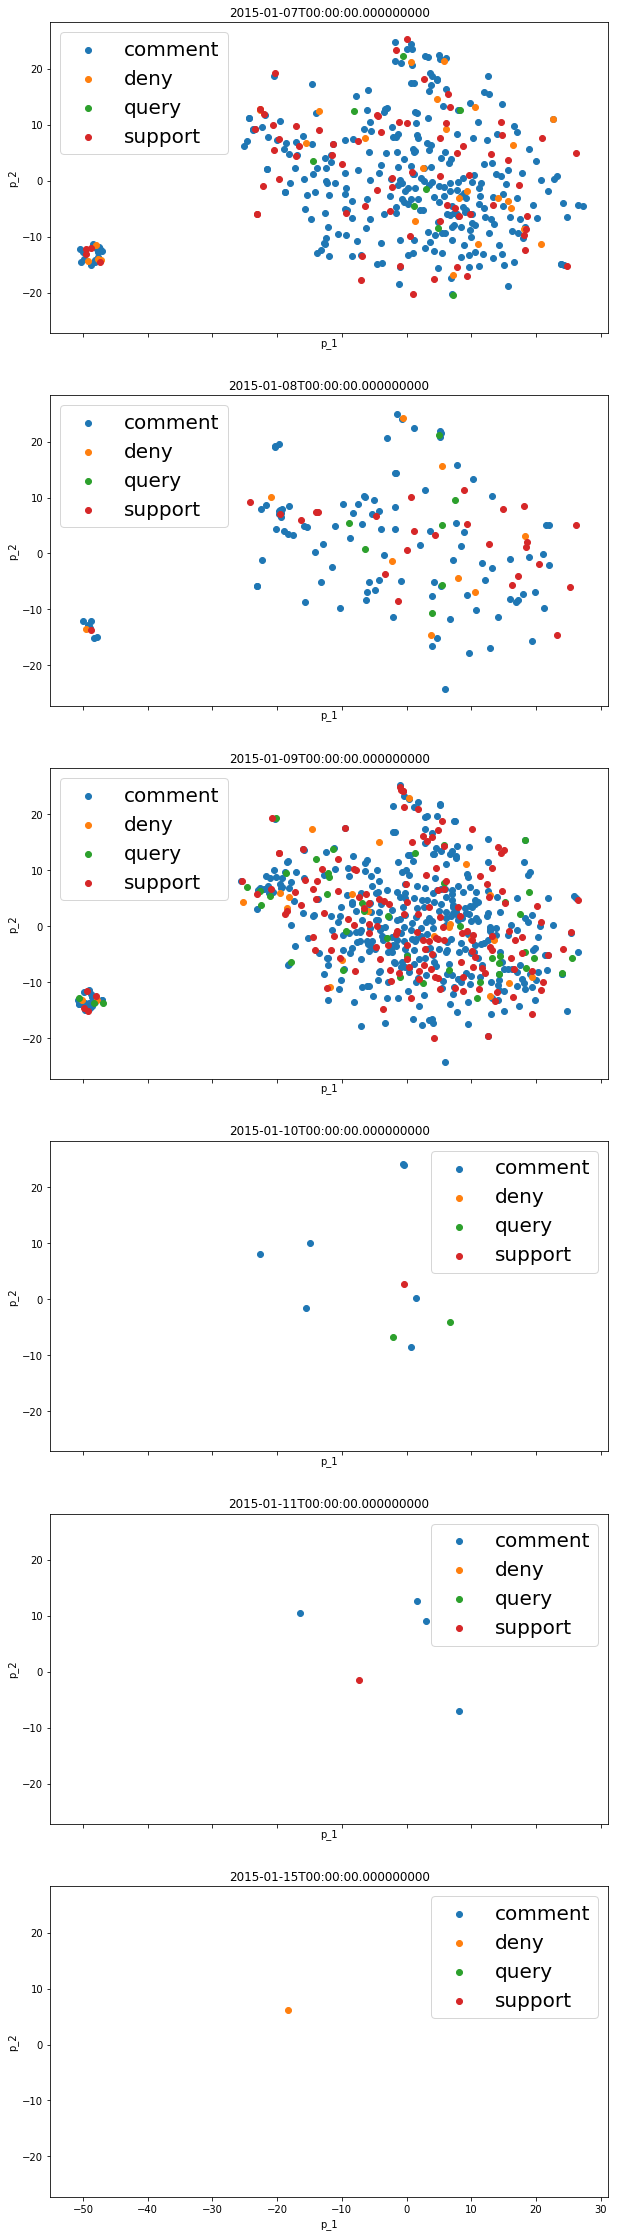

In [14]:
# Initialize figure
fig, ax = plt.subplots(nrows=len(dates), sharex=True, sharey=True, figsize=(10, 40))

# Loop over days
for d, date in enumerate(dates):
    
    # Take indices of today
    ix_d = (dates_ == date)
    
    # Split data
    X_d = Xb[ix_d, :]
    Y_d = Y[ix_d]
    
    for l, label in enumerate(labels):

        ax[d].scatter(X_d[(Y_d == l), 0], X_d[(Y_d == l), 1], label=label)
        ax[d].set_title(date)
        ax[d].set_xlabel('p_1')
        ax[d].set_ylabel('p_2')
        ax[d].legend(fontsize=fS)
    
plt.show()

### Naive  classifier

In [15]:
# Preallocate performance array
perf_array = []
days_array = []
rums_array = []

# Loop over days
for d in range(1, len(dates)-1):

    # Set range up to yesterday
    past = range(d)

    # Create training data from all previous days
    trn_index = tweets_r['date'].isin(dates[past]).values

    # Find all tweets from today
    tst_index = (tweets_r['date'] == dates[d]).values.tolist()

    # Split out training data
    trn_X = X[trn_index, :]
    trn_Y = Y[trn_index]

    # Split out test data
    tst_X = X[tst_index, :]
    tst_Y = Y[tst_index]

    # Define classifier
    if classifier in ('lr', 'logr', 'logistic'):
        
        # Linear logistic model
        clf = linear_model.LogisticRegression(C=l2)
        
    elif classifier in ('svm', 'svc'):
        
        # Polynomial support vector machine
        clf = svm.SVC(kernel='poly', degree=degree, verbose=True)
        
    else:
        raise ValueError('Classifier not recognized')

    # Train classifier on data from previous days
    clf.fit(trn_X, trn_Y)

    # Make predictions on test set
    preds = clf.predict(tst_X)

    # Test on data from current day and store
    perf_array.append(np.mean(preds == tst_Y))

    # Store day and rumour
    days_array.append(dates[d])

# Compact to DataFrame
results = pd.DataFrame({'dates': days_array,
                        'acc_naive': perf_array,})


/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM][LibSVM]

/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]

/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]

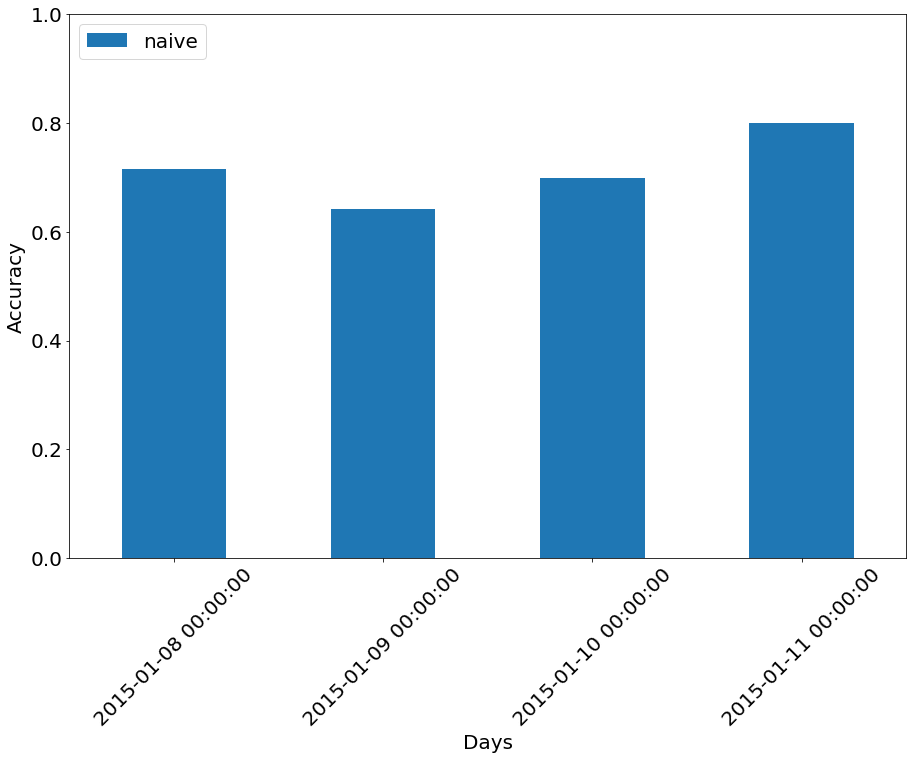

In [16]:
# Visualize performance in bar graph

# Initialize figure
fig, ax = plt.subplots(figsize=(15, 10))

# Bar plot
results.plot.bar(ax=ax, x='dates', rot=45, fontsize=fS);

# Set axes properties
ax.set_ylim([0, 1]);
ax.legend({'naive'}, fontsize=fS, loc=2);
ax.set_xlabel('Days', fontsize=fS);
ax.set_ylabel('Accuracy', fontsize=fS);

### An importance-weighted classifier

In [17]:
# Preallocate performance array
perf_array = []
iw = []

# Loop over days
for d in range(1, len(dates)-1):

    # Set range up to yesterday
    past = range(d)

    # Create training data from all previous days
    trn_index = tweets_r['date'].isin(dates[past]).values

    # Find all tweets from today
    tst_index = (tweets_r['date'] == dates[d]).values.tolist()

    # Split out training data
    trn_X = X[trn_index, :]
    trn_Y = Y[trn_index]

    # Split out test data
    tst_X = X[tst_index, :]
    tst_Y = Y[tst_index]
    
    # Define classifier
    if classifier in ('lr', 'logr', 'logistic'):
        
        # Linear logistic model
        clf = linear_model.LogisticRegression(C=l2)
        
    elif classifier in ('svm', 'svc'):
        
        # Polynomial support vector machine
        clf = svm.SVC(kernel=kernel, verbose=True, C=l2)
        
    else:
        raise ValueError('Classifier not recognized')

    # Obtain weights
    aclf = ImportanceWeightedClassifier()
    W = aclf.iwe_kernel_mean_matching(trn_X, tst_X, distance='cityblock', lb=1, self_normalize=True) 
#     W = aclf.iwe_logistic_discrimination(trn_X, tst_X, l2=10000, self_normalize=True) + 1
    iw.append(W)

    # Train classifier on labeled data from previous days and unlabeled data from today
    clf.fit(trn_X, trn_Y, W)

    # Make predictions on test set
    preds = clf.predict(tst_X)

    # Test on data from current day and store
    perf_array.append(np.mean(preds == tst_Y))

# Compact to DataFrame
results['acc_adaptive'] = pd.Series(perf_array, index=results.index)


     pcost       dcost       gap    pres   dres
 0:  4.5665e+02  2.7958e+03  9e+04  3e-01  2e+00
 1:  2.8468e+03  6.6840e+03  3e+04  1e-01  5e-01
 2:  9.2528e+03  8.6975e+03  7e+03  1e-02  7e-02
 3:  9.5037e+03  8.7736e+03  8e+02  8e-05  5e-04
 4:  9.3053e+03  9.0360e+03  3e+02  2e-05  1e-04
 5:  9.2638e+03  8.9982e+03  3e+02  2e-05  1e-04
 6:  9.0622e+03  9.0248e+03  4e+01  7e-07  4e-06
 7:  9.0445e+03  9.0438e+03  6e-01  1e-08  7e-08
 8:  9.0440e+03  9.0440e+03  6e-03  1e-10  7e-10
Optimal solution found.
[LibSVM]

/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


     pcost       dcost       gap    pres   dres
 0: -6.5322e+02  3.5316e+03  9e+04  2e-01  1e+00
 1:  5.8025e+03  1.4211e+04  3e+04  5e-02  4e-01
 2:  1.4240e+04  1.7191e+04  2e+04  2e-02  1e-01
 3:  1.6722e+04  1.6889e+04  1e+04  1e-02  1e-01
 4:  1.8129e+04  1.7291e+04  1e+03  1e-04  1e-03
 5:  1.7900e+04  1.7598e+04  3e+02  4e-05  3e-04
 6:  1.7848e+04  1.7546e+04  3e+02  3e-05  3e-04
 7:  1.7620e+04  1.7597e+04  2e+01  5e-07  4e-06
 8:  1.7606e+04  1.7606e+04  3e-01  6e-09  5e-08
 9:  1.7606e+04  1.7606e+04  3e-03  6e-11  5e-10
Optimal solution found.
[LibSVM]

/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


     pcost       dcost       gap    pres   dres
 0: -8.7665e+03  4.4567e+03  5e+05  2e-01  1e+00
 1:  4.9532e+03  4.2494e+04  1e+05  5e-02  2e-01
 2:  3.7483e+04  6.7691e+04  4e+04  2e-02  8e-02
 3:  7.1882e+04  7.3424e+04  3e+03  9e-04  4e-03
 4:  7.3198e+04  7.3626e+04  9e+02  3e-04  1e-03
 5:  7.3225e+04  7.3527e+04  9e+02  2e-04  1e-03
 6:  7.3626e+04  7.3645e+04  7e+01  2e-05  9e-05
 7:  7.3646e+04  7.3646e+04  7e-01  2e-07  9e-07
 8:  7.3646e+04  7.3646e+04  7e-03  2e-09  9e-09
Optimal solution found.
[LibSVM]

/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


     pcost       dcost       gap    pres   dres
 0: -4.4900e+03  6.8280e+03  2e+06  8e-01  1e+00
 1: -2.1313e+03  1.0612e+04  1e+06  6e-01  9e-01
 2: -9.6421e+02  2.0713e+04  1e+06  4e-01  6e-01
 3:  4.2649e+03  3.3164e+04  6e+05  2e-01  3e-01
 4:  9.1945e+03  3.8218e+04  6e+05  2e-01  2e-01
 5:  3.1065e+04  5.6950e+04  5e+04  2e-02  3e-02
 6:  6.2424e+04  6.3043e+04  2e+03  6e-04  9e-04
 7:  6.3430e+04  6.3455e+04  5e+02  1e-04  2e-04
 8:  6.3582e+04  6.3371e+04  5e+02  7e-05  1e-04
 9:  6.3477e+04  6.3469e+04  2e+01  2e-06  3e-06
10:  6.3470e+04  6.3470e+04  2e-01  2e-08  3e-08
11:  6.3470e+04  6.3470e+04  2e-03  2e-10  3e-10
Optimal solution found.
[LibSVM]

/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


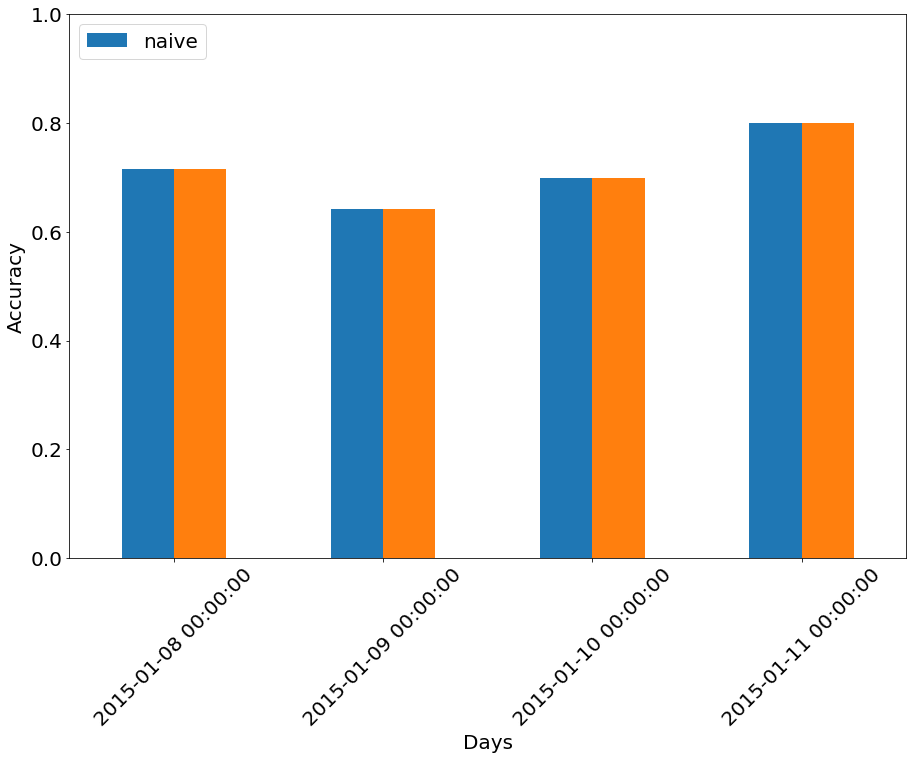

In [18]:
# Visualize performance in bar graph

# Initialize figure
fig, ax = plt.subplots(figsize=(15, 10))

# Bar plot
results.plot.bar(ax=ax, x='dates', rot=45, fontsize=fS);

# Set axes properties
ax.set_ylim([0, 1]);
ax.legend({'naive'}, fontsize=fS, loc=2);
ax.set_xlabel('Days', fontsize=fS);
ax.set_ylabel('Accuracy', fontsize=fS);

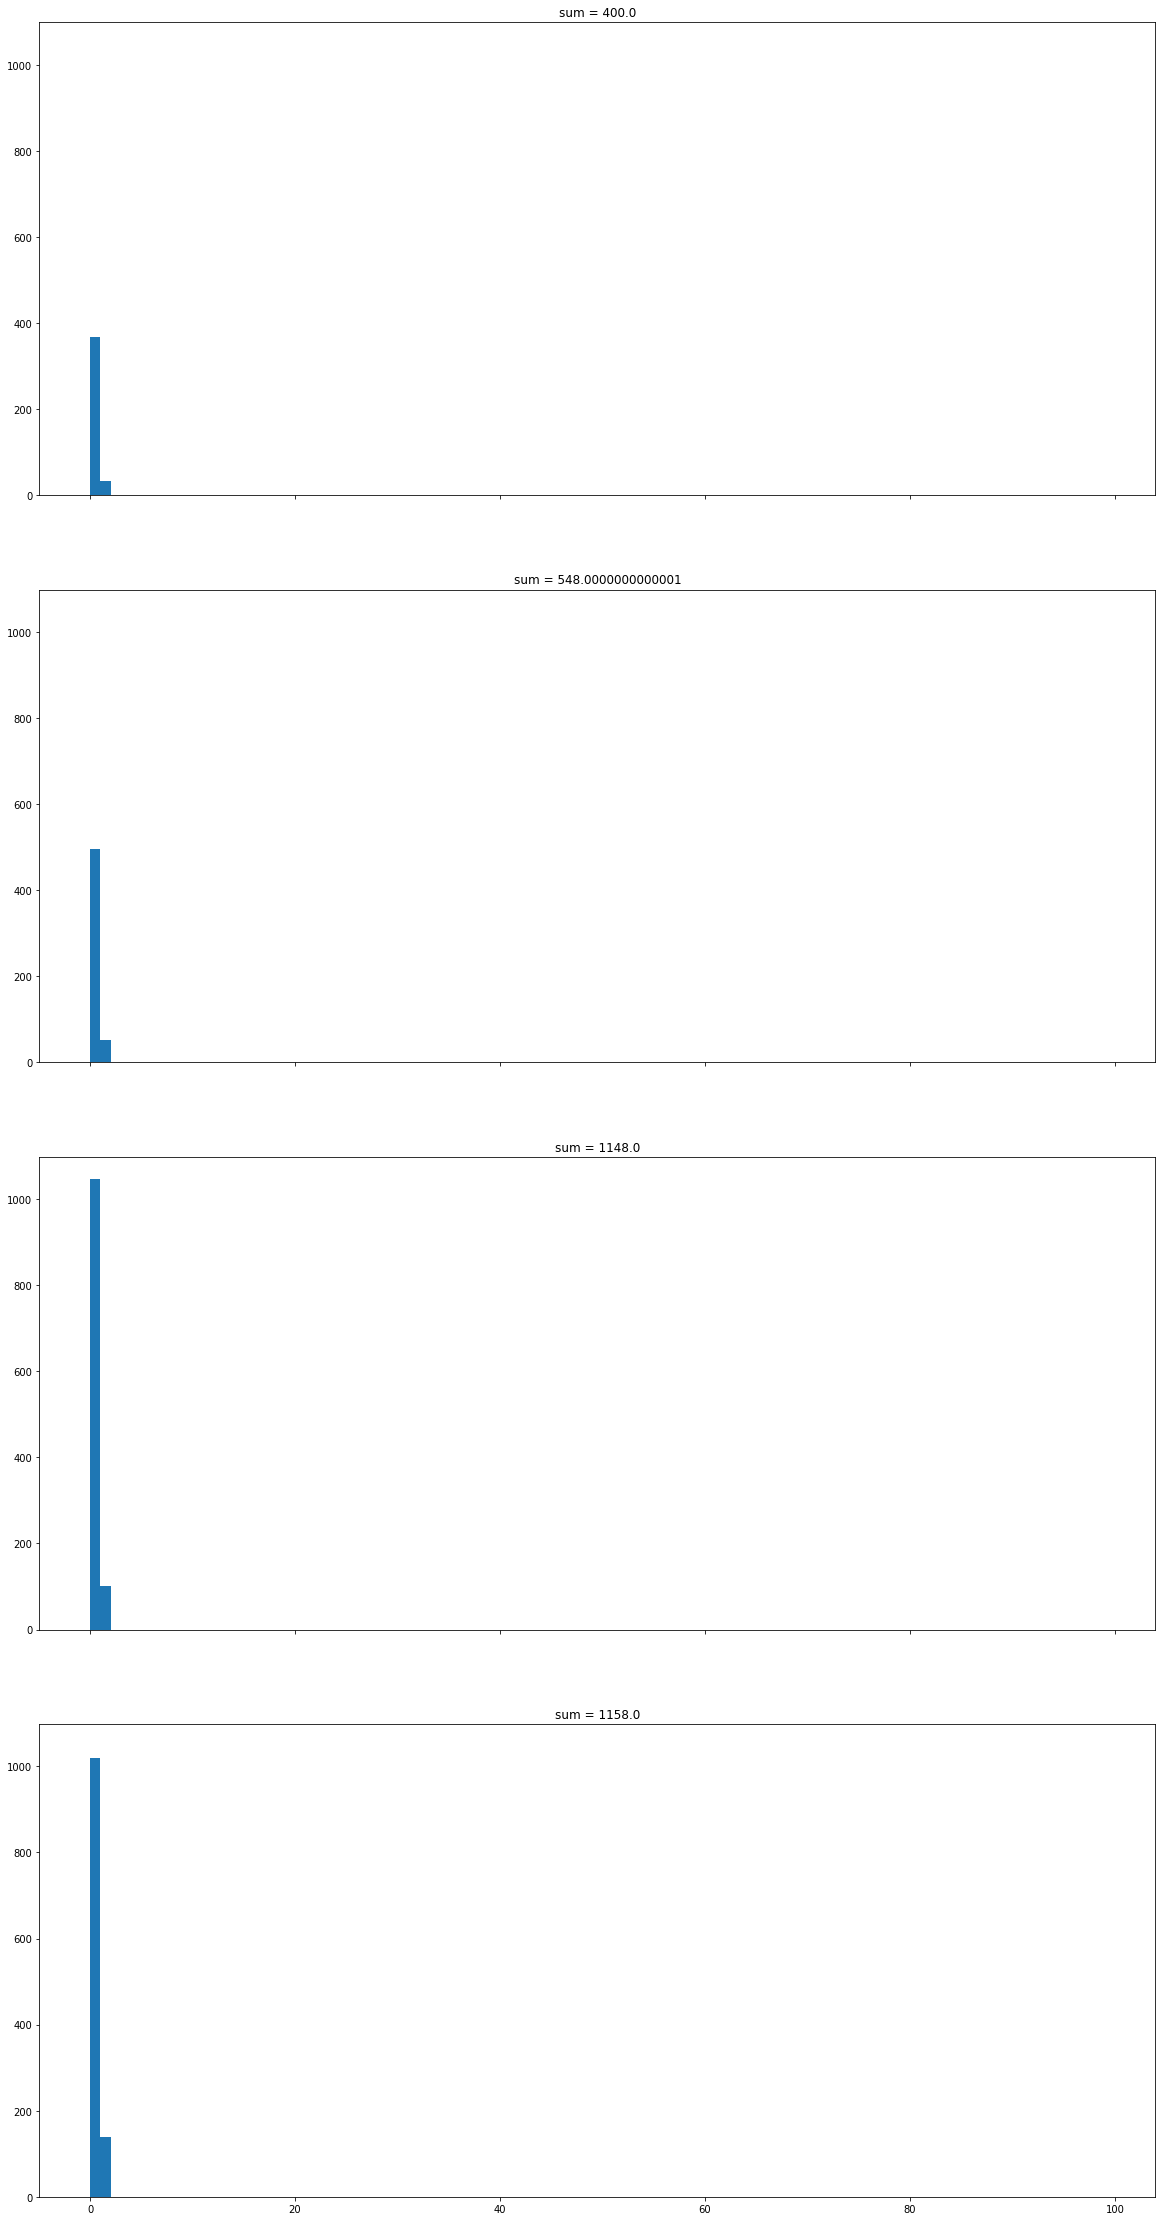

In [19]:
fig, ax = plt.subplots(nrows=len(iw), sharex=True, sharey=True, figsize=(20,40))

for d, iw_d in enumerate(iw):
    ax[d].hist(iw_d, np.arange(100))
    ax[d].set_title('sum = ' + str(np.sum(iw_d)))

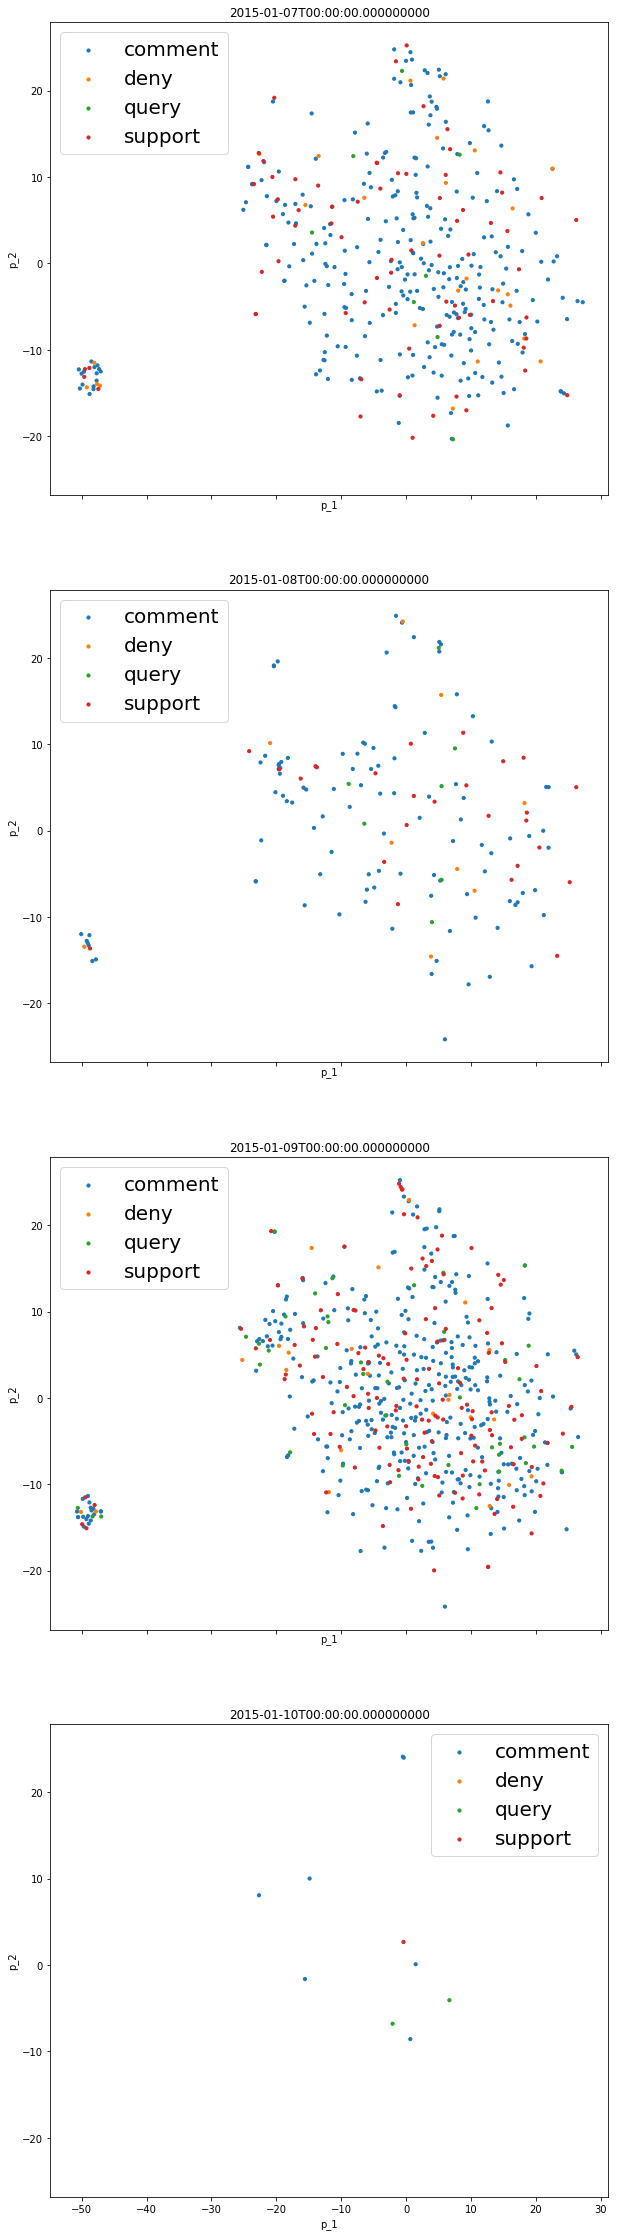

In [20]:
# Initialize figure
fig, ax = plt.subplots(nrows=len(dates)-2, sharex=True, sharey=True, figsize=(10, 40))

# Loop over days
for d, date in enumerate(dates[:-2]):
    
    # Take indices of today
    ix_d = (dates_ == date)
    
    # Split data
    X_d = Xb[ix_d, :]
    Y_d = Y[ix_d]
    
    siw = iw[d][-np.sum(ix_d):]
    
    for l, label in enumerate(labels):

        ax[d].scatter(X_d[(Y_d == l), 0], X_d[(Y_d == l), 1], s=siw*10, label=label)
        ax[d].set_title(date)
        ax[d].set_xlabel('p_1')
        ax[d].set_ylabel('p_2')
        ax[d].legend(fontsize=fS)
    
plt.show()

## Sequential prediction over rumours

In [21]:
# Load data
X = np.load('../data/RumEval2019/rumeval19.npy')
tweets = pd.read_json('../data/RumEval2019/RumEval19.json')

X[np.isnan(X)] = 0

In [22]:
# Subselect labels and map to numerical
labels_ = tweets['label'].values.tolist()
labels = np.unique(labels_)
Y = np.array([np.argwhere(label == labels)[0][0] for label in labels_])

In [23]:
tweets = tweets.sort_values(by=['date'])

In [24]:
dates_ = tweets['date'].values
dates = np.unique(tweets['date'].values)
sortix = np.argsort(dates_)

['ferguson',
 'ebola-essien',
 'ottawashooting',
 'prince-toronto',
 'sydneysiege',
 'charliehebdo',
 'putinmissing',
 'germanwings-crash',
 'illary']

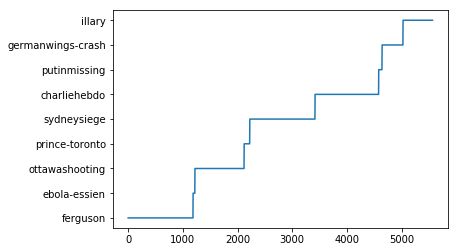

In [25]:
rumours_ = tweets['rumour'].values[sortix]
indexes = np.unique(rumours_, return_index=True)[1]
rumours = [rumours_[index] for index in sorted(indexes)]

plt.plot(rumours_)
rumours

In [26]:
# Sort embedding
X = X[sortix, :]

In [27]:
# Preallocate performance array
nperf_array = []
aperf_array = []
iw = []


# Start looping over rumours
for r in range(1, len(rumours)-1):
    
    print('At rumour ' + rumours[r])
    
    # Set range up to yesterday
    past = slice(0,r)

    # Create training data from all previous days
    trn_index = tweets['rumour'].isin(rumours[past]).values

    # Find all tweets from today
    tst_index = (tweets['rumour'] == rumours[r]).values.tolist()

    # Split out training data
    trn_X = X[trn_index, :]
    trn_Y = Y[trn_index]

    # Split out test data
    tst_X = X[tst_index, :]
    tst_Y = Y[tst_index]
    
    # Define classifier
    if classifier in ('lr', 'logr', 'logistic'):
        
        # Linear logistic model
        nclf = linear_model.LogisticRegression(C=l2)
        aclf = linear_model.LogisticRegression(C=l2)
        
    elif classifier in ('svm', 'svc'):
        
        # Polynomial support vector machine
        nclf = svm.SVC(kernel=kernel, verbose=True, C=l2)
        aclf = svm.SVC(kernel=kernel, verbose=True, C=l2)
        
    else:
        raise ValueError('Classifier not recognized')

    # Obtain weights
    iwe_ = ImportanceWeightedClassifier()
    W = iwe_.iwe_kernel_mean_matching(trn_X, tst_X, distance='euclidean', lb=0, self_normalize=True) + 1
#     W = iwe_.iwe_logistic_discrimination(trn_X, tst_X, l2=10000, self_normalize=True) + 1
#     W = iwe_.iwe_nearest_neighbours(trn_X, tst_X, self_normalize=True)
    iw.append(W)

    # Train classifier on labeled data from previous days and unlabeled data from today
    nclf.fit(trn_X, trn_Y)
    aclf.fit(trn_X, trn_Y, W)

    # Make predictions on test set
    npreds = nclf.predict(tst_X)
    apreds = aclf.predict(tst_X)

    # Test on data from current day and store
    nperf_array.append(np.mean(npreds == tst_Y))
    aperf_array.append(np.mean(apreds == tst_Y))

# Compact to DataFrame
rum_results = pd.DataFrame({'rumours': rumours[1:8],
                            'acc_naive': nperf_array,
                            'acc_adaptive': aperf_array})    

At rumour ebola-essien
     pcost       dcost       gap    pres   dres
 0:  3.5167e+05  6.1786e+05  3e+08  1e+01  6e-01
 1:  9.8035e+05  6.3364e+05  8e+06  2e-01  1e-02
 2:  1.3663e+06  9.5789e+05  4e+05  1e-15  2e-11
 3:  1.2712e+06  1.1621e+06  1e+05  6e-16  5e-12
 4:  1.1999e+06  1.1813e+06  2e+04  2e-15  3e-12
 5:  1.1849e+06  1.1843e+06  6e+02  1e-15  5e-12
 6:  1.1844e+06  1.1844e+06  9e+00  9e-16  2e-11
 7:  1.1844e+06  1.1844e+06  1e-01  1e-15  1e-10
Optimal solution found.
[LibSVM]

/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]At rumour ottawashooting
     pcost       dcost       gap    pres   dres
 0:  3.4979e+05  6.3294e+05  3e+08  1e+01  6e-01
 1:  1.0110e+06  6.5779e+05  9e+06  2e-01  1e-02
 2:  1.4469e+06  1.0281e+06  4e+05  2e-15  2e-11
 3:  1.3496e+06  1.2372e+06  1e+05  1e-15  3e-12
 4:  1.2773e+06  1.2577e+06  2e+04  5e-16  2e-12
 5:  1.2620e+06  1.2608e+06  1e+03  2e-15  5e-12
 6:  1.2610e+06  1.2610e+06  2e+01  2e-16  2e-11
 7:  1.2610e+06  1.2610e+06  2e-01  1e-15  1e-10
Optimal solution found.
[LibSVM]

/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]At rumour prince-toronto
     pcost       dcost       gap    pres   dres
 0:  9.6344e+05  1.7252e+06  2e+09  1e+01  6e-01
 1:  2.8472e+06  1.7905e+06  4e+07  3e-01  1e-02
 2:  4.1479e+06  3.1253e+06  2e+06  7e-03  3e-04
 3:  4.0905e+06  3.7251e+06  5e+05  2e-03  8e-05
 4:  3.9187e+06  3.7885e+06  1e+05  2e-15  4e-12
 5:  3.8154e+06  3.8072e+06  8e+03  2e-15  2e-12
 6:  3.8083e+06  3.8080e+06  3e+02  2e-15  1e-11
 7:  3.8081e+06  3.8081e+06  5e+00  4e-15  2e-10
 8:  3.8081e+06  3.8081e+06  6e-02  1e-15  5e-10
Optimal solution found.
[LibSVM]

/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]At rumour sydneysiege
     pcost       dcost       gap    pres   dres
 0:  1.0891e+06  1.9209e+06  2e+09  1e+01  6e-01
 1:  3.1604e+06  1.9809e+06  4e+07  3e-01  1e-02
 2:  4.5593e+06  3.4241e+06  2e+06  7e-03  3e-04
 3:  4.5031e+06  4.1020e+06  6e+05  2e-03  8e-05
 4:  4.3120e+06  4.1684e+06  1e+05  1e-15  6e-12
 5:  4.1984e+06  4.1894e+06  9e+03  4e-15  2e-12
 6:  4.1906e+06  4.1903e+06  3e+02  4e-15  1e-11
 7:  4.1904e+06  4.1904e+06  9e+00  3e-15  3e-10
 8:  4.1904e+06  4.1904e+06  7e-01  6e-16  2e-09
Optimal solution found.
[LibSVM]

/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]At rumour charliehebdo
     pcost       dcost       gap    pres   dres
 0:  2.2700e+06  4.0417e+06  7e+09  2e+01  5e-01
 1:  6.9105e+06  4.2067e+06  1e+08  3e-01  1e-02
 2:  1.0107e+07  8.1005e+06  8e+06  2e-02  5e-04
 3:  1.0733e+07  9.7173e+06  2e+06  3e-03  9e-05
 4:  1.0423e+07  9.8398e+06  6e+05  7e-05  2e-06
 5:  1.0012e+07  9.9305e+06  8e+04  3e-06  1e-07
 6:  9.9438e+06  9.9401e+06  4e+03  1e-07  4e-09
 7:  9.9405e+06  9.9404e+06  8e+01  2e-09  3e-11
 8:  9.9404e+06  9.9404e+06  4e+00  3e-11  3e-09
Optimal solution found.
[LibSVM]

/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]At rumour putinmissing
     pcost       dcost       gap    pres   dres
 0:  3.8155e+06  6.8591e+06  2e+10  2e+01  5e-01
 1:  1.1934e+07  7.1886e+06  3e+08  4e-01  1e-02
 2:  1.7504e+07  1.4539e+07  2e+07  2e-02  5e-04
 3:  1.9516e+07  1.7492e+07  3e+06  2e-03  6e-05
 4:  1.9016e+07  1.7669e+07  1e+06  1e-04  3e-06
 5:  1.8033e+07  1.7898e+07  1e+05  3e-06  8e-08
 6:  1.7923e+07  1.7917e+07  6e+03  1e-07  3e-09
 7:  1.7918e+07  1.7917e+07  9e+01  1e-09  1e-10
 8:  1.7917e+07  1.7917e+07  9e-01  1e-11  4e-10
Optimal solution found.
[LibSVM]

/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]At rumour germanwings-crash
     pcost       dcost       gap    pres   dres
 0:  4.2375e+06  7.3405e+06  2e+10  2e+01  5e-01
 1:  1.2576e+07  7.6368e+06  4e+08  4e-01  1e-02
 2:  1.8146e+07  1.4801e+07  2e+07  2e-02  5e-04
 3:  2.0036e+07  1.7896e+07  3e+06  2e-03  6e-05
 4:  1.9387e+07  1.8071e+07  1e+06  9e-05  3e-06
 5:  1.8463e+07  1.8290e+07  2e+05  6e-06  2e-07
 6:  1.8324e+07  1.8317e+07  8e+03  1e-07  4e-09
 7:  1.8317e+07  1.8317e+07  2e+02  3e-09  7e-11
 8:  1.8317e+07  1.8317e+07  2e+00  3e-11  6e-10
Optimal solution found.
[LibSVM]

/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/wmkouw/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]

(array([4.601e+03, 7.000e+00, 6.000e+00, 5.000e+00, 1.100e+01, 2.000e+00,
        4.000e+00, 1.000e+00, 3.000e+00, 3.000e+00]),
 array([  1.00000025,  24.928286  ,  48.85657175,  72.7848575 ,
         96.71314325, 120.641429  , 144.56971475, 168.4980005 ,
        192.42628625, 216.354572  , 240.28285775]),
 <a list of 10 Patch objects>)

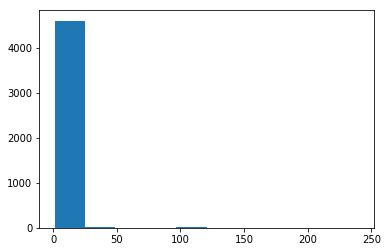

In [28]:
plt.hist(iw[-1])

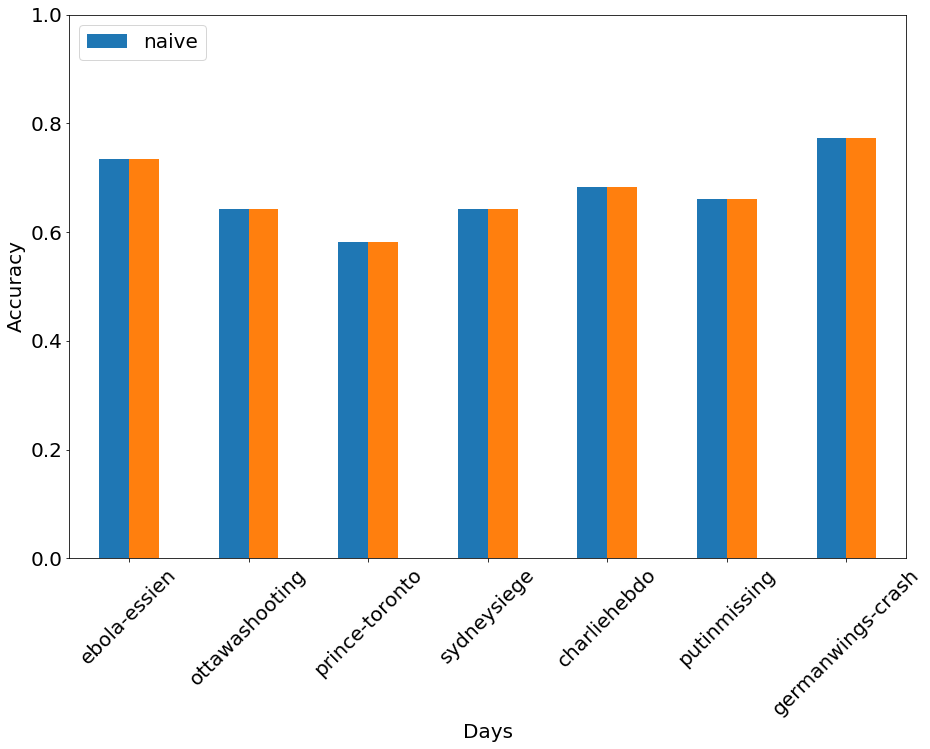

In [29]:
# Visualize performance in bar graph

# Initialize figure
fig, ax = plt.subplots(figsize=(15, 10))

# Bar plot
rum_results.plot.bar(ax=ax, x='rumours', rot=45, fontsize=fS);

# Set axes properties
ax.set_ylim([0, 1]);
ax.legend({'naive'}, fontsize=fS, loc=2);
ax.set_xlabel('Days', fontsize=fS);
ax.set_ylabel('Accuracy', fontsize=fS);